## 1: Installasi Paket yang Diperlukan

Pada bagian pertama, kita menginstal paket yang diperlukan, seperti mediapipe yang digunakan untuk ekstraksi landmark dari gambar tangan.

In [ ]:
# REKOMENDASI: Menginstal versi pustaka yang spesifik untuk stabilitas dan reproduktifitas.
# Ini mencegah eror akibat konflik dependensi yang sering terjadi.
!pip install --quiet --upgrade tensorflow mediapipe opencv-python-headless scikit-learn seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 148.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow-deci

##2: Impor Modul yang Diperlukan
Di sini, kita mengimpor berbagai modul yang digunakan untuk pemrosesan gambar, pembuatan model deep learning, dan evaluasi model.

In [ ]:
# REKOMENDASI: Mengelompokkan impor sesuai standar PEP 8 untuk meningkatkan keterbacaan.

# --- Pustaka Pihak Ketiga (Utama) ---
import tensorflow as tf
import mediapipe as mp
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- Modul Spesifik ---
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping # REKOMENDASI: Menambahkan EarlyStopping

# --- Koneksi Google Drive ---
drive.mount('/content/drive')

# --- Verifikasi Versi ---
print("TensorFlow version:", tf.__version__)
print("MediaPipe version:", mp.__version__)

Mounted at /content/drive
TensorFlow version: 2.19.1
MediaPipe version: 0.10.21


mediapipe digunakan untuk mendeteksi landmark pada gambar tangan.

tensorflow digunakan untuk membuat dan melatih model deep learning.

##3: Konfigurasi Model dan Dataset
Bagian ini mengonfigurasi beberapa parameter untuk pelatihan model, seperti pemilihan metode (SIBI atau BISINDO), jalur dataset, ukuran gambar, batch size, dan jumlah epoch. Di sini juga dilakukan inisialisasi MediaPipe untuk mendeteksi tangan.

In [ ]:
# --- KONFIGURASI PROYEK ---
# REKOMENDASI: Menjaga semua variabel konfigurasi di satu tempat adalah praktik yang sangat baik.

# Pilihan Metode: 'SIBI' atau 'BISINDO'
METODE = 'SIBI'

if METODE == 'SIBI':
    # REKOMENDASI: Pastikan path ini sesuai dengan lokasi dataset di Google Drive Anda.
    DATA_DIR = '/content/drive/MyDrive/Skripsi/dataset/SIBI_augmentend'
    LANDMARK_DIR = '/content/drive/MyDrive/Skripsi/dataset/SIBI_landmarks'
    MAX_HANDS = 1
    OUTPUT_MODEL_NAME = 'sibi_hybrid_model'
else:
    DATA_DIR = '/content/drive/MyDrive/Skripsi/dataset/BISINDO'
    LANDMARK_DIR = '/content/drive/MyDrive/Skripsi/dataset/BISINDO_landmarks'
    MAX_HANDS = 2
    OUTPUT_MODEL_NAME = 'bisindo_hybrid_model'

# Konfigurasi Model & Training
IMAGE_SIZE = (128, 128)
NUM_LANDMARKS = 42 * 3  # 21 landmarks * 3 (x,y,z) * 2 tangan (untuk konsistensi input)
BATCH_SIZE = 32
EPOCHS = 100 # Meningkatkan jumlah epoch awal, akan dikontrol oleh EarlyStopping
FINE_TUNE_EPOCHS = 50
RANDOM_STATE = 42 # Untuk reproduktifitas

# --- Inisialisasi MediaPipe ---
mp_hands = mp.solutions.hands
hands_model = mp_hands.Hands(static_image_mode=True, max_num_hands=MAX_HANDS, min_detection_confidence=0.5)

Variabel `METODE` digunakan untuk memilih dataset yang akan digunakan, yaitu SIBI atau BISINDO.

Inisialisasi model `MediaPipe` untuk mendeteksi tangan dalam gambar.

##4: Fungsi Generator Data
Pada bagian ini, kita menulis fungsi `data_generator()` untuk menghasilkan data berupa gambar dan landmark. Setiap gambar diubah menjadi RGB, dan landmark tangan diekstrak menggunakan `MediaPipe.`

In [ ]:
# --- TAHAP 1 & 2: KUMPULKAN PATH DAN BAGI DATASET ---
print("Memuat path gambar...")
image_paths = sorted(glob.glob(f'{DATA_DIR}/*/*.jpg'))
if not image_paths:
    raise ValueError(f"Tidak ada gambar yang ditemukan di direktori: {DATA_DIR}.")

CLASS_NAMES = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(CLASS_NAMES)
label_to_int = {label: i for i, label in enumerate(CLASS_NAMES)}
int_labels = [label_to_int[path.split('/')[-2]] for path in image_paths]

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, int_labels, test_size=0.30, random_state=RANDOM_STATE, stratify=int_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=RANDOM_STATE, stratify=temp_labels)

print(f"Jumlah data training: {len(train_paths)}")
print(f"Jumlah data validasi: {len(val_paths)}")
print(f"Jumlah data uji: {len(test_paths)}")

# --- TAHAP 3: FUNGSI PEMROSESAN DATA (RINGAN DAN EFISIEN) ---
def _load_numpy(path_tensor):
    # Fungsi untuk memuat file .npy
    return np.load(path_tensor.numpy())

@tf.function
def load_precomputed_data(image_path, label):
    # 1. Muat gambar
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, IMAGE_SIZE)
    img_float = tf.cast(img_resized, tf.float32)

    # 2. Dapatkan path landmark .npy yang sesuai
    landmark_path = tf.strings.regex_replace(image_path, DATA_DIR, LANDMARK_DIR)
    landmark_path = tf.strings.regex_replace(landmark_path, ".jpg", ".npy")

    # 3. Muat landmark yang sudah diproses
    landmarks = tf.py_function(_load_numpy, [landmark_path], tf.float32)
    landmarks.set_shape((NUM_LANDMARKS,))

    return {'image_input': img_float, 'landmark_input': landmarks}, label

# --- TAHAP 4: MEMBUAT PIPELINE tf.data ---
def create_dataset(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_precomputed_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()  # SEKARANG .cache() AMAN DIGUNAKAN KARENA PROSESNYA RINGAN
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_paths, train_labels)
validation_dataset = create_dataset(val_paths, val_labels)
test_dataset = create_dataset(test_paths, test_labels)

print("\nPipeline data dari data yang sudah diproses telah siap.")

Memuat path gambar...
Jumlah data training: 7007
Jumlah data validasi: 1501
Jumlah data uji: 1502

Pipeline data dari data yang sudah diproses telah siap.


Fungsi ini menghasilkan pasangan data: gambar dan landmark tangan.

`MediaPipe` digunakan untuk mendeteksi dan mengekstrak landmark tangan dari gambar yang ada.

##6: Augmentasi Data dan Pembentukan Model
Pada bagian ini, kita menambahkan augmentasi data, membangun cabang visual (CNN) menggunakan `EfficientNetB0`, serta cabang landmark menggunakan MLP.

In [ ]:
# REKOMENDASI: Memberi nama pada setiap layer input dan model utama untuk kejelasan.

# --- LAPISAN AUGMENTASI DATA ---
# Diterapkan sebagai bagian dari model agar berjalan di GPU, lebih efisien.
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# --- CABANG 1: FITUR VISUAL (CNN) ---
# Menggunakan EfficientNetB0 yang sudah terlatih pada ImageNet (Transfer Learning).
input_image = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
augmented_image = data_augmentation(input_image)

# Menggunakan layer Rescaling terpisah agar model pre-trained bisa digunakan.
rescaling_layer = layers.Rescaling(1./127.5, offset=-1)
rescaled_image = rescaling_layer(augmented_image)

base_model_cnn = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=rescaled_image
)
base_model_cnn.trainable = False # Bekukan bobot pre-trained untuk pelatihan awal

visual_features = GlobalAveragePooling2D(name='visual_feature_extractor')(base_model_cnn.output)

# --- CABANG 2: FITUR GEOMETRIS (MLP) ---
# Memproses data landmark tangan untuk memahami postur.
input_landmarks = Input(shape=(NUM_LANDMARKS,), name='landmark_input')
x = Dense(256, activation='relu')(input_landmarks)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
landmark_features = Dense(64, activation='relu', name='landmark_feature_extractor')(x)

# --- PENGGABUNGAN (MERGING) & KLASIFIKASI ---
# Menggabungkan fitur dari kedua cabang untuk membuat prediksi akhir.
combined_features = Concatenate(name='combine_features')([visual_features, landmark_features])
x = Dropout(0.5)(combined_features)
output = Dense(NUM_CLASSES, activation='softmax', name='classifier')(x)

# --- MEMBUAT & KOMPILASI MODEL ---
model = Model(inputs=[input_image, input_landmarks], outputs=output, name="SignBridge_Hybrid_Model")
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "SignBridge_Hybrid_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc

 Total params: 4,156,860 (15.86 MB)

 Trainable params: 107,289 (419.10 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Augmentasi data dilakukan dengan berbagai teknik untuk meningkatkan keberagaman data pelatihan.

Model CNN menggunakan `EfficientNetB0` dan dilatih pada data gambar, sedangkan model landmark adalah MLP yang dilatih pada data landmark.

Gabungan kedua cabang ini menghasilkan output klasifikasi.

##7: Pelatihan Model
Di sini kita melatih model menggunakan data pelatihan yang telah disiapkan.

Model dilatih dengan callback `ReduceLROnPlatea` yang akan menurunkan learning rate jika model tidak mengalami peningkatan pada validation loss

--- Memulai Pelatihan Awal (Transfer Learning) ---
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2607s 12s/step - accuracy: 0.1272 - loss: 2.9067 - val_accuracy: 0.6176 - val_loss: 1.2361 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5309 - loss: 1.2716 - val_accuracy: 0.8401 - val_loss: 0.5120 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7424 - loss: 0.7049 - val_accuracy: 0.8801 - val_loss: 0.3139 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8104 - loss: 0.5118 - val_accuracy: 0.9667 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8470 - loss: 0.4097 - val_accuracy: 0.9380 - val_loss: 0.1805 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8683 - loss: 0.3509 - val_accuracy: 0.9647 - val_loss: 0.1425 - learning_rate: 0.0010
Epoch 7/100
219/219 ━━━

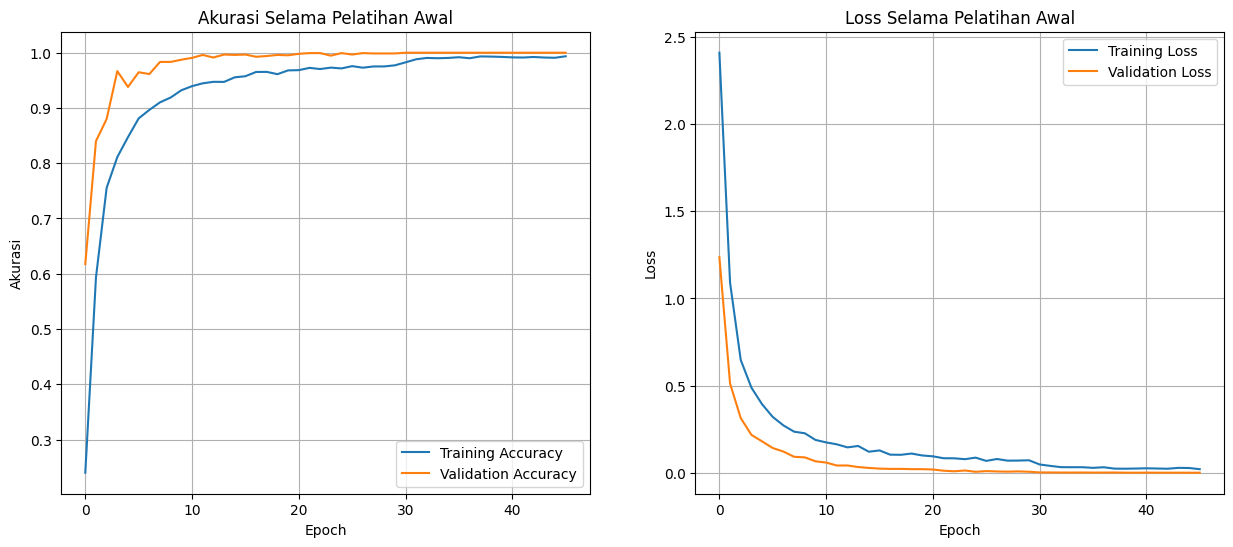

In [ ]:
print("--- Memulai Pelatihan Awal (Transfer Learning) ---")

# REKOMENDASI: Gunakan EarlyStopping untuk menghentikan training saat tidak ada kemajuan
# dan menyimpan bobot terbaik secara otomatis.
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15, # Jumlah epoch tanpa peningkatan sebelum berhenti
    verbose=1,
    mode='max', # Berhenti saat akurasi berhenti meningkat
    restore_best_weights=True # Kembalikan bobot dari epoch terbaik
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Faktor pengurangan learning rate
    patience=5,  # Jumlah epoch tanpa peningkatan loss sebelum lr dikurangi
    verbose=1,
    min_lr=1e-6 # Learning rate minimum
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS, # Tetapkan batas epoch yang tinggi, biarkan EarlyStopping yang menghentikan
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# REKOMENDASI: Visualisasi yang jelas sangat penting untuk analisis.
plt.figure(figsize=(15, 6))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Selama Pelatihan Awal')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Selama Pelatihan Awal')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

##8: Evaluasi Model dengan F1-Score

Setelah pelatihan selesai, kita akan mengevaluasi model menggunakan F1-score.

--- Contoh Hasil Deteksi Landmark MediaPipe ---


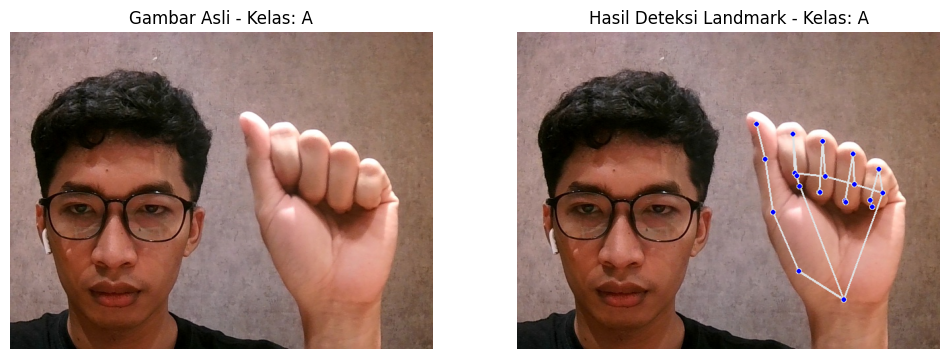

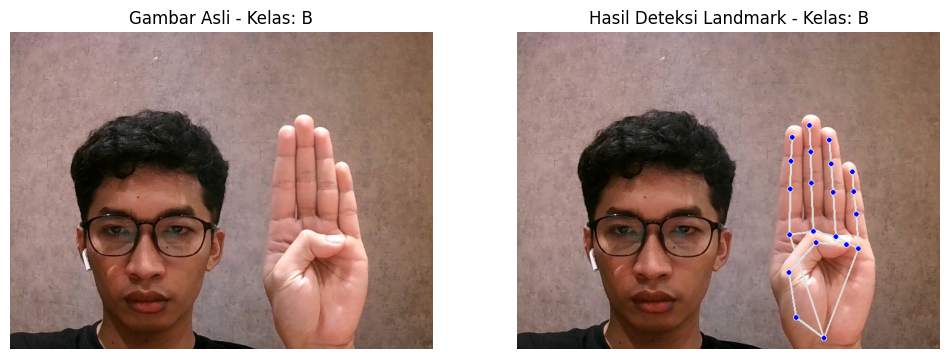

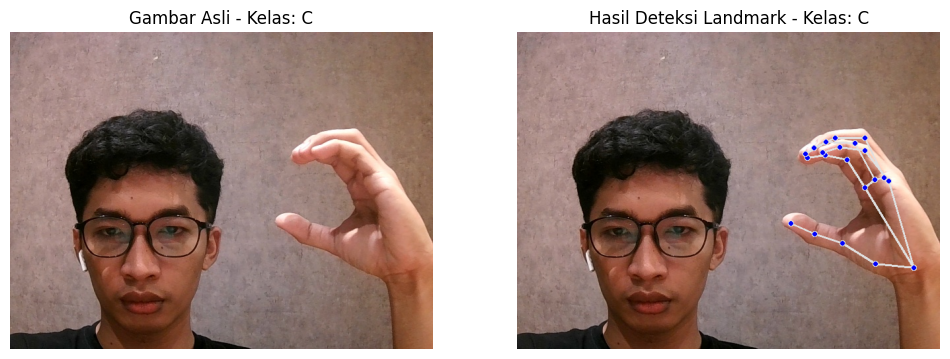

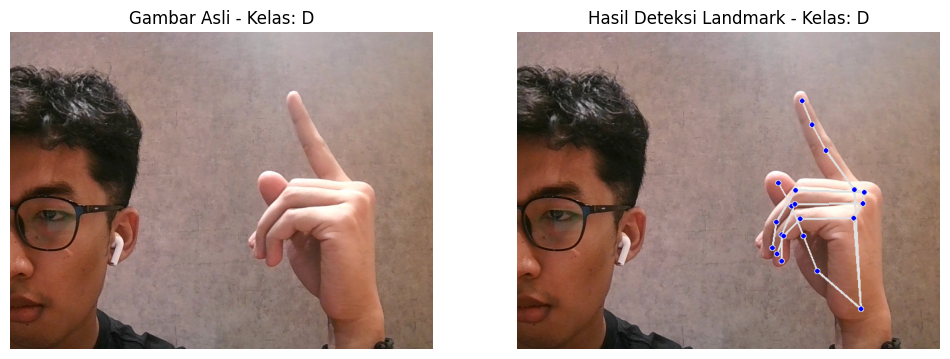

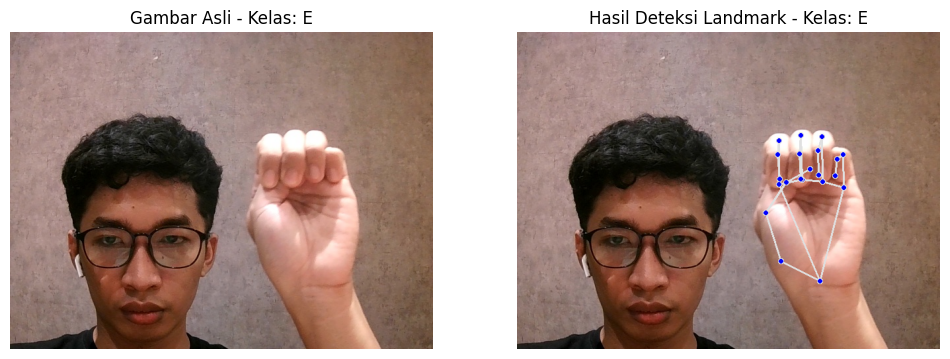

In [ ]:
# REKOMENDASI: Sel ini bagus untuk verifikasi visual. Tidak ada perubahan fungsional,
# hanya perbaikan kecil pada struktur untuk keterbacaan.

def show_landmarks_on_image(image_path, class_name):
    """Fungsi utilitas untuk menampilkan gambar asli dan overlay landmark."""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands_model.process(image_rgb)

    image_with_landmarks = image_rgb.copy()
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image_with_landmarks,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS
            )

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f"Gambar Asli - Kelas: {class_name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image_with_landmarks)
    plt.title(f"Hasil Deteksi Landmark - Kelas: {class_name}")
    plt.axis("off")

    plt.show()

# Menampilkan 1 contoh gambar dari 5 kelas pertama
print("--- Contoh Hasil Deteksi Landmark MediaPipe ---")
for class_name in CLASS_NAMES[:5]:
    image_path = os.path.join(DATA_DIR, class_name, os.listdir(os.path.join(DATA_DIR, class_name))[0])
    show_landmarks_on_image(image_path, class_name)

##9: Menyimpan Model yang Telah Ditraining

Setelah evaluasi, kita menyimpan model yang telah dilatih untuk digunakan di masa depan.

In [ ]:
# REKOMENDASI: Membuat direktori model jika belum ada.
# Karena EarlyStopping(restore_best_weights=True) digunakan, model yang disimpan
# adalah model dengan performa validasi terbaik.
model_save_path = f'/content/drive/MyDrive/Skripsi/models/{OUTPUT_MODEL_NAME}_final.keras'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model.save(model_save_path)
print(f"Model berhasil disimpan di: '{model_save_path}'")

Model berhasil disimpan di: '/content/drive/MyDrive/Skripsi/models/sibi_hybrid_model_final.keras'


--- Memuat Model Final untuk Evaluasi Akhir ---

--- Mengevaluasi Model pada Test Set ---
47/47 ━━━━━━━━━━━━━━━━━━━━ 462s 10s/step - accuracy: 1.0000 - loss: 0.0027
Test Loss    : 0.0024
Test Accuracy: 1.0000

--- Membuat Laporan Klasifikasi dan Confusion Matrix ---
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step

Laporan Klasifikasi:

              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000        60
           B     1.0000    1.0000    1.0000        60
           C     1.0000    1.0000    1.0000        60
           D     1.0000    1.0000    1.0000        60
           E     1.0000    1.0000    1.0000        60
           F     1.0000    1.0000    1.0000        60
           G     1.0000    1.0000    1.0000        60
           H     1.0000    1.0000    1.0000        60
           I     1.0000    1.0000    1.0000        60
           J     1.0000    1.0000    1.0000        60
           K     1.0000    1.0000    1.0000        60
           L     1.00

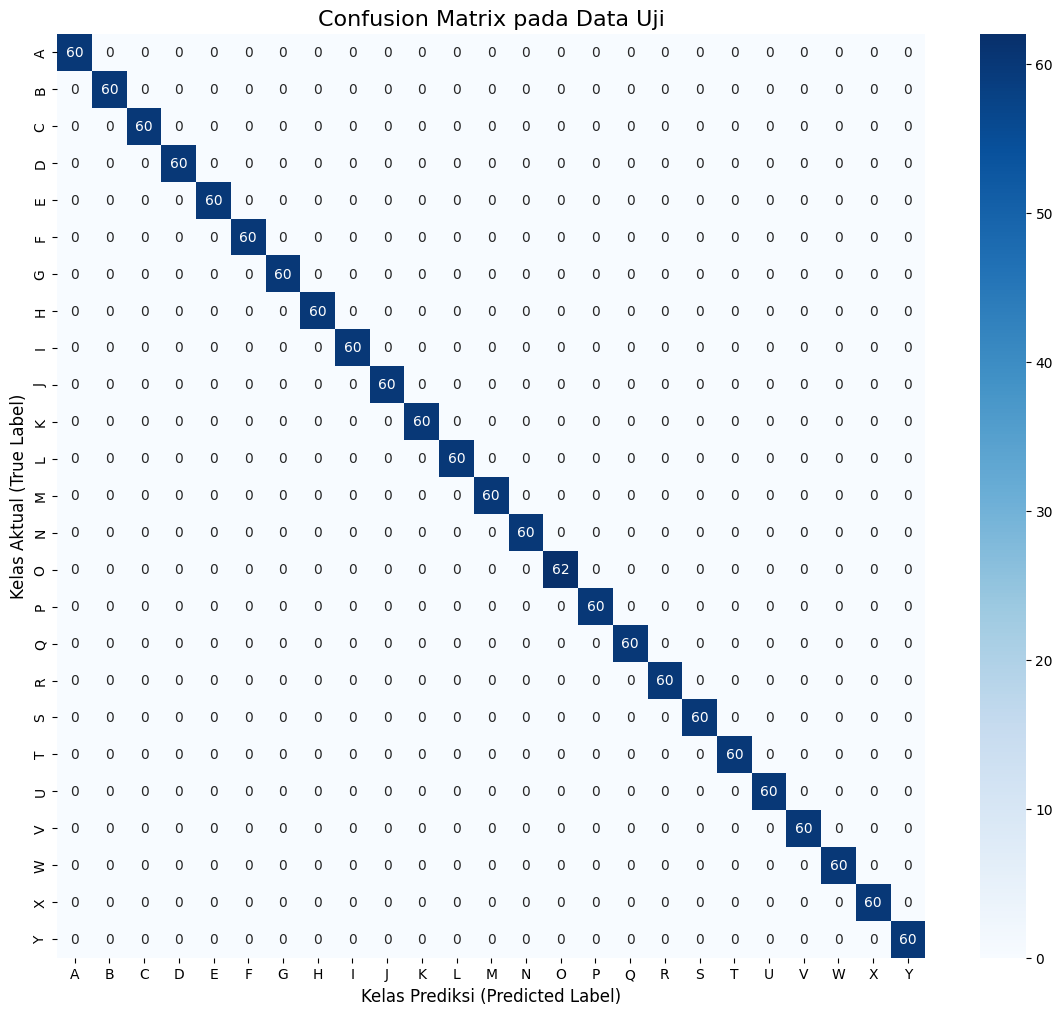

In [ ]:
# REKOMENDASI: Evaluasi akhir pada data uji (test set) adalah langkah paling krusial
# untuk mengukur performa model yang sebenarnya pada data yang belum pernah dilihat.

print("--- Memuat Model Final untuk Evaluasi Akhir ---")
final_model = tf.keras.models.load_model(model_save_path)

print("\n--- Mengevaluasi Model pada Test Set ---")
loss, accuracy = final_model.evaluate(test_dataset)
print(f"Test Loss    : {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

print("\n--- Membuat Laporan Klasifikasi dan Confusion Matrix ---")
y_pred_probs = final_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Laporan Klasifikasi (Presisi, Recall, F1-Score)
print("\nLaporan Klasifikasi:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix pada Data Uji', fontsize=16)
plt.ylabel('Kelas Aktual (True Label)', fontsize=12)
plt.xlabel('Kelas Prediksi (Predicted Label)', fontsize=12)
plt.show()